# Poverty Prediction using Machine Learning
### Python for Data Science Final Project
### Audrey Zhang

The goal of this project is to build a predictive model to predict the probability that an individual lives below the poverty line (Poverty Probability Index, or PPI) using a set of metrics about the individual's life. 

The dataset was obtained from Kaggle.com and can be downloaded here:

https://www.kaggle.com/johnnyyiu/predicting-poverty

In [1]:
# Import libraries

import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from math import sqrt
%matplotlib inline

In [45]:
features=pd.read_csv('./predicting-poverty/train_values.csv')

In [46]:
values=pd.read_csv('./predicting-poverty/train_labels.csv')

In [47]:
features.shape

(12600, 59)

In [48]:
values.shape

(12600, 2)

In [49]:
features.head(2)

,row_id,country,is_urban,age,female,married,religion,relationship_to_hh_head,education_level,literacy,...,reg_formal_nbfi_account,financially_included,active_bank_user,active_mm_user,active_formal_nbfi_user,active_informal_nbfi_user,nonreg_active_mm_user,num_formal_institutions_last_year,num_informal_institutions_last_year,num_financial_activities_last_year
0,0,C,False,18.0,True,True,P,Other,1.0,True,...,False,True,True,False,False,False,False,1,0,1
1,1,C,True,30.0,True,True,P,Other,1.0,True,...,False,True,True,False,False,False,False,1,0,0


In [50]:
values.head(2)

,row_id,poverty_probability
0,0,0.515
1,1,0.981


In [51]:
# merge features and values for data cleaning

ppi_df=features.merge(values, on='row_id')

In [52]:
# check for missing values

ppi_df.isnull().sum()

row_id                                       0
country                                      0
is_urban                                     0
age                                          0
female                                       0
married                                      0
religion                                     0
relationship_to_hh_head                      0
education_level                            236
literacy                                     0
can_add                                      0
can_divide                                   0
can_calc_percents                            0
can_calc_compounding                         0
employed_last_year                           0
employment_category_last_year                0
employment_type_last_year                    0
share_hh_income_provided                   305
income_ag_livestock_last_year                0
income_friends_family_last_year              0
income_government_last_year                  0
income_own_bu

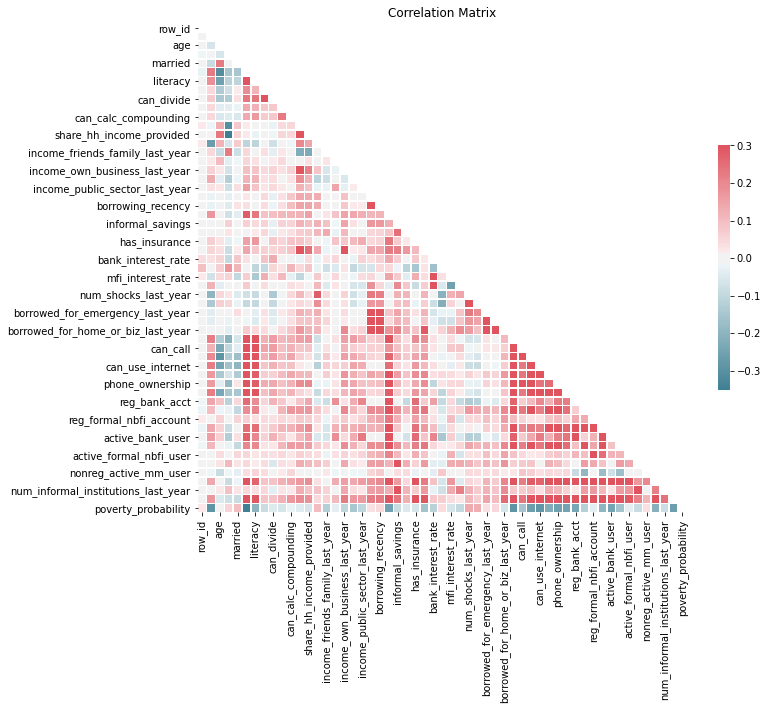

In [53]:
# Compute the correlation matrix
corr = ppi_df.corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

ax.set_title('Correlation Matrix')

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

In [54]:
# drop columns with the most missing values

ppi_df.drop('bank_interest_rate', axis = 1, inplace = True)
ppi_df.drop('mm_interest_rate', axis = 1, inplace = True)
ppi_df.drop('mfi_interest_rate', axis = 1, inplace = True)
ppi_df.drop('other_fsp_interest_rate', axis = 1, inplace = True)

In [55]:
# for remaining two variables, check what percentage of data is missing
# for education_level:
ppi_df['education_level'].isnull().sum()/ppi_df['education_level'].isnull().count()

0.01873015873015873

In [56]:
# for share_hh_income_provided:
ppi_df['share_hh_income_provided'].isnull().sum()/ppi_df['share_hh_income_provided'].isnull().count()

0.024206349206349207

In [57]:
# since both percentages are quite small, we can fill in the missing values
# first explore the two variables
ppi_df['education_level'].unique().tolist()

[1.0, 0.0, 2.0, 3.0, nan]

In [58]:
# since this is a discrete variable with four available values
# we can use the mode to fill in the missing values

ppi_df.education_level.fillna(ppi_df.education_level.mode()[0], inplace=True)

In [16]:
# now for share_hh_income_provided

ppi_df['share_hh_income_provided'].unique().tolist()

[1.0, nan, 2.0, 5.0, 3.0, 4.0]

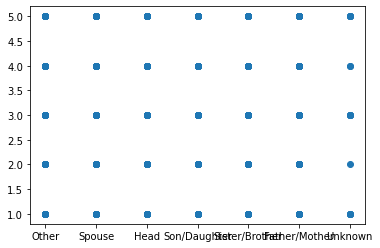

In [17]:
# this is also a discrete variable with five available values
# however, it is possible that this is tied to relationship to hh head 

plt.scatter(ppi_df['relationship_to_hh_head'], ppi_df['share_hh_income_provided'])

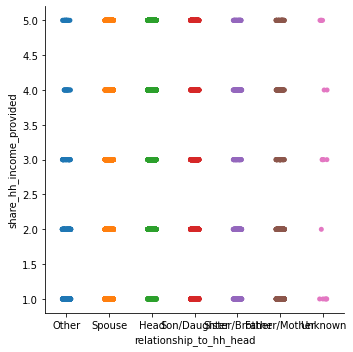

In [18]:
# use a seaborn plot function to give a better visualiation

sns.catplot(x="relationship_to_hh_head", y="share_hh_income_provided", data=ppi_df)

In [19]:
# there is no immediate apparent trend that emerges
# I will also use the mode to fill in the missing data for this variable

ppi_df.share_hh_income_provided.fillna(ppi_df.share_hh_income_provided.mode()[0], inplace=True)

In [20]:
# double check that all missing values are cleaned

ppi_df.isnull().sum().sort_values

<bound method Series.sort_values of row_id                                   0
country                                  0
is_urban                                 0
age                                      0
female                                   0
married                                  0
religion                                 0
relationship_to_hh_head                  0
education_level                          0
literacy                                 0
can_add                                  0
can_divide                               0
can_calc_percents                        0
can_calc_compounding                     0
employed_last_year                       0
employment_category_last_year            0
employment_type_last_year                0
share_hh_income_provided                 0
income_ag_livestock_last_year            0
income_friends_family_last_year          0
income_government_last_year              0
income_own_business_last_year            0
income_private_sec

In [42]:
# now we will check the data type of each variable and convert boolean or categorical variables

ppi_df.dtypes

row_id                                     int64
country                                   object
is_urban                                    bool
age                                      float64
female                                      bool
married                                     bool
religion                                  object
relationship_to_hh_head                   object
education_level                          float64
literacy                                    bool
can_add                                     bool
can_divide                                  bool
can_calc_percents                           bool
can_calc_compounding                        bool
employed_last_year                          bool
employment_category_last_year             object
employment_type_last_year                 object
share_hh_income_provided                 float64
income_ag_livestock_last_year               bool
income_friends_family_last_year             bool
income_government_la

In [59]:
# first, replace boolean values

for col in ppi_df.select_dtypes(include=[bool]):
    ppi_df[col].replace(True, 1, inplace=True)
    #ppi_df[col].replace(False, 1, inplace=True)

In [60]:
ppi_df['female'].sum()

7028.0

In [23]:
ppi_df.dtypes

row_id                                     int64
country                                   object
is_urban                                 float64
age                                      float64
female                                   float64
married                                  float64
religion                                  object
relationship_to_hh_head                   object
education_level                          float64
literacy                                 float64
can_add                                  float64
can_divide                               float64
can_calc_percents                        float64
can_calc_compounding                     float64
employed_last_year                       float64
employment_category_last_year             object
employment_type_last_year                 object
share_hh_income_provided                 float64
income_ag_livestock_last_year            float64
income_friends_family_last_year          float64
income_government_la

In [391]:
# change remaining object variables into categories and assign category codes

for col in ppi_df.select_dtypes(include=[object]):
    ppi_df[col] = ppi_df[col].astype('category')
    ppi_df[col]=ppi_df[col].cat.codes


In [392]:
# final check

ppi_df.dtypes

row_id                                     int64
country                                     int8
is_urban                                 float64
age                                      float64
female                                   float64
married                                  float64
religion                                    int8
relationship_to_hh_head                     int8
education_level                          float64
literacy                                 float64
can_add                                  float64
can_divide                               float64
can_calc_percents                        float64
can_calc_compounding                     float64
employed_last_year                       float64
employment_category_last_year               int8
employment_type_last_year                   int8
share_hh_income_provided                 float64
income_ag_livestock_last_year            float64
income_friends_family_last_year          float64
income_government_la

In [394]:
# there may be confounding variables in the dataset 
# here we define some functions to find the variables highly correlated with each other

def get_redundant_pairs(df):
    pairs_to_drop = set()
    cols = df.columns
    for i in range(0, df.shape[1]):
        for j in range(0, i+1):
            pairs_to_drop.add((cols[i], cols[j]))
    return pairs_to_drop


def get_top_abs_correlations(df, n=10):
    au_corr = df.corr().abs().unstack()
    labels_to_drop = get_redundant_pairs(df)
    au_corr = au_corr.drop(labels=labels_to_drop).sort_values(ascending=False)
    return au_corr[0:n]

get_top_abs_correlations(ppi_df)

num_times_borrowed_last_year       borrowing_recency                     0.839256
num_formal_institutions_last_year  num_financial_activities_last_year    0.774544
phone_technology                   phone_ownership                       0.757191
num_shocks_last_year               avg_shock_strength_last_year          0.678588
relationship_to_hh_head            share_hh_income_provided              0.463842
country                            religion                              0.456666
phone_technology                   num_financial_activities_last_year    0.443644
education_level                    phone_technology                      0.439176
phone_technology                   num_formal_institutions_last_year     0.406812
phone_ownership                    num_formal_institutions_last_year     0.372796
dtype: float64

In [395]:
# because some explanatory variables are highly correlated, we will drop some of them
# this will help us avoid multicollinearity 

ppi_df.drop('borrowing_recency', axis = 1, inplace = True)
ppi_df.drop('employed_last_year', axis = 1, inplace = True)
ppi_df.drop('employment_category_last_year', axis = 1, inplace = True)
ppi_df.drop('num_formal_institutions_last_year', axis = 1, inplace = True)
ppi_df.drop('num_shocks_last_year', axis = 1, inplace = True)

In [396]:
# now we will define the features of the model

list_of_vars = ppi_df.columns.tolist()
list_of_vars.remove('row_id')
list_of_vars.remove('poverty_probability')

In [397]:
features=list_of_vars

In [398]:
target=['poverty_probability']

In [469]:
X=ppi_df[features]
y=ppi_df[target]

In [470]:
# here we will split up the train and test datasets

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=324)

In [471]:
regressor = LinearRegression()
regressor.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [472]:
y_prediction = regressor.predict(X_test)
y_prediction

array([[0.79306216],
       [1.00535917],
       [0.4389168 ],
       ...,
       [0.62389136],
       [0.77898849],
       [0.54874377]])

In [474]:
# original values for comparison

y_train.describe()

,poverty_probability
count,10080.000000
mean,0.610946
std,0.291567
min,0.000000
25%,0.394000
50%,0.633000
75%,0.879000
max,1.000000


In [475]:
# use the root mean square error to assess fit

RMSE1 = sqrt(mean_squared_error(y_true = y_test, y_pred = y_prediction))

In [476]:
print(RMSE1)

0.25112192280256507


In [477]:
# RMSE is quite large for a probability index of between 0 and 1
# try reducing the number of features to improve the model

features_reduced=['age', 
                  'female', 
                  'is_urban',
                  'married', 
                  'religion', 
                  'education_level',
                  'num_times_borrowed_last_year',
                  'phone_ownership',
                  'financially_included']

In [478]:
X1=ppi_df[features_reduced]

In [479]:
X_train, X_test, y_train, y_test = train_test_split(X1, y, test_size=0.2, random_state=324)

In [480]:
regressor1 = LinearRegression()
regressor1.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [481]:
y_prediction = regressor1.predict(X_test)
y_prediction

array([[0.67777297],
       [0.8454907 ],
       [0.50467973],
       ...,
       [0.78863534],
       [0.67909188],
       [0.64126351]])

In [482]:
# explore the predicted values

y_test.describe()

,poverty_probability
count,2520.000000
mean,0.612575
std,0.291164
min,0.000000
25%,0.394000
50%,0.633000
75%,0.886000
max,1.000000


In [483]:
RMSE2 = sqrt(mean_squared_error(y_true = y_test, y_pred = y_prediction))

In [484]:
print(RMSE2)

0.2668154968769119


In [485]:
# reducing number of features did not improve RMSE

# because most independent variables have a small range of values 
# but some variables have a large range of values
# try rerunning model after scaling
from sklearn.preprocessing import StandardScaler

In [419]:
X2 = StandardScaler().fit_transform(ppi_df[features])

In [486]:
# test model with scaled features, using all features
X_train, X_test, y_train, y_test = train_test_split(X2, y, test_size=0.2, random_state=324)
regressor1 = LinearRegression()
regressor1.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [487]:
y_prediction = regressor1.predict(X_test)
y_prediction

array([[0.7846682 ],
       [1.00562184],
       [0.4360937 ],
       ...,
       [0.62114234],
       [0.77433333],
       [0.55415862]])

In [488]:
RMSE3 = sqrt(mean_squared_error(y_true = y_test, y_pred = y_prediction))

In [489]:
print(RMSE3)

0.25115042160464285


In [546]:
# try this on the reduced features dataset

X3 = StandardScaler().fit_transform(ppi_df[features_reduced])
X_train, X_test, y_train, y_test = train_test_split(X3, y, test_size=0.2, random_state=324)
regressor1_a = LinearRegression()
regressor1_a.fit(X_train, y_train)

y_prediction = regressor1_a.predict(X_test)
y_prediction

array([[0.67777297],
       [0.8454907 ],
       [0.50467973],
       ...,
       [0.78863534],
       [0.67909188],
       [0.64126351]])

In [547]:
RMSE3_a = sqrt(mean_squared_error(y_true = y_test, y_pred = y_prediction))
print(RMSE3_a)

0.26681549687691186


In [551]:
# try a ridge regression 
# we will use the scaled version of the dataset with full features
X_train, X_test, y_train, y_test = train_test_split(X2, y, test_size=0.2, random_state=324)

from sklearn.linear_model import Ridge
regressor2 = Ridge()
regressor2.fit(X_train, y_train)

Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None,
      normalize=False, random_state=None, solver='auto', tol=0.001)

In [552]:
y_prediction = regressor2.predict(X_test)
y_prediction

array([[0.79304806],
       [1.0053235 ],
       [0.43893125],
       ...,
       [0.62391117],
       [0.77896008],
       [0.54876586]])

In [553]:
RMSE4 = sqrt(mean_squared_error(y_true = y_test, y_pred = y_prediction))
print(RMSE4)

0.251121338819598


In [495]:
#try a Lasso regression

from sklearn.linear_model import Lasso

regressor3 = Lasso()
regressor3.fit(X_train, y_train)

Lasso(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=1000,
      normalize=False, positive=False, precompute=False, random_state=None,
      selection='cyclic', tol=0.0001, warm_start=False)

In [496]:
y_prediction = regressor3.predict(X_test)
y_prediction

array([0.61094573, 0.61094573, 0.61094573, ..., 0.61094573, 0.61094573,
       0.61094573])

In [497]:
RMSE5 = sqrt(mean_squared_error(y_true = y_test, y_pred = y_prediction))
print(RMSE5)

0.291110717967974


In [498]:
from sklearn.linear_model import ElasticNet

regressor4=ElasticNet()
regressor4.fit(X_train, y_train)

ElasticNet(alpha=1.0, copy_X=True, fit_intercept=True, l1_ratio=0.5,
           max_iter=1000, normalize=False, positive=False, precompute=False,
           random_state=None, selection='cyclic', tol=0.0001, warm_start=False)

In [499]:
y_prediction = regressor4.predict(X_test)
y_prediction

array([0.61094573, 0.61094573, 0.61094573, ..., 0.61094573, 0.61094573,
       0.61094573])

In [500]:
RMSE6 = sqrt(mean_squared_error(y_true = y_test, y_pred = y_prediction))
print(RMSE6)

# it looks like the original linear regression model provides the smallest RMSE 

0.291110717967974


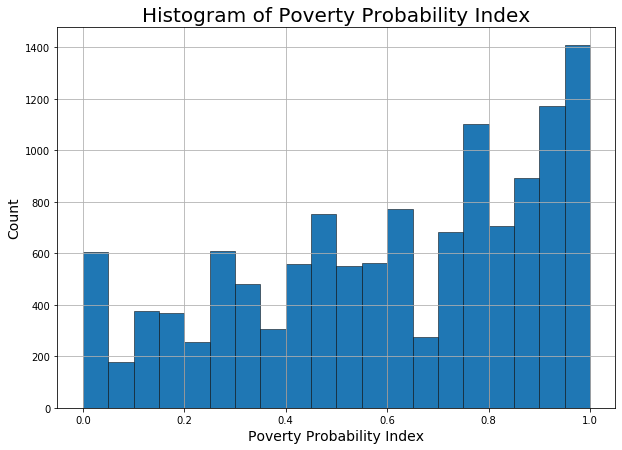

In [561]:
# plot poverty probability 

fig, ax = plt.subplots(figsize=(10, 7))

plt.hist(ppi_df['poverty_probability'], 20, edgecolor='black', linewidth=0.5)

plt.xlabel('Poverty Probability Index', fontsize=14)
plt.ylabel('Count', fontsize=14)
plt.title('Histogram of Poverty Probability Index', fontsize=20)

plt.grid(True)

plt.show()



In [449]:
# sum of square of residuals
ssr = np.sum((y_prediction - y_test['poverty_probability'])**2)

#  total sum of squares
sst = np.sum((y_test['poverty_probability'] - np.mean(y_test['poverty_probability']))**2)

# R2 score
r2_score = 1 - (ssr/sst)

In [450]:
print(r2_score)

-7.022041508708554e-06


In [502]:
#create dataframe of RMSE for comparison

data = [['linear regression on full features', RMSE1], 
        ['linear regression on reduced features', RMSE2],
        ['linear regression on scaled full features', RMSE3],
       ['Ridge regression on scaled full features', RMSE4],
       ['Lasso regression on scaled full features ', RMSE5],
       ['ElasticNet regression on full features', RMSE6]]
  
# Create the pandas DataFrame 
df = pd.DataFrame(data, columns = ['Model', 'RMSE']) 
  
# print dataframe. 
df 

,Model,RMSE
0,linear regression on full features,0.251122
1,linear regression on reduced features,0.266815
2,linear regression on scaled full features,0.251150
3,Ridge regression on scaled full features,0.251121
4,Lasso regression on scaled full features,0.291111
5,ElasticNet regression on full features,0.291111


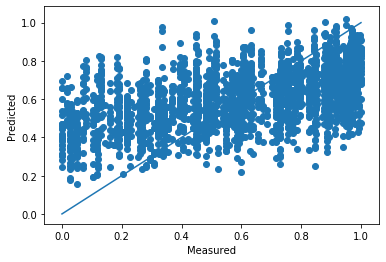

In [516]:
# plot the predicted vs measured values
y_prediction = regressor2.predict(X_test)
y_prediction

fig, ax = plt.subplots()
ax.scatter(y_test, y_prediction)
ax.plot([y.min(), y.max()], [y.min(), y.max()])
ax.set_xlabel('Measured')
ax.set_ylabel('Predicted')
plt.show()

Text(0, 0.5, 'Residuals')

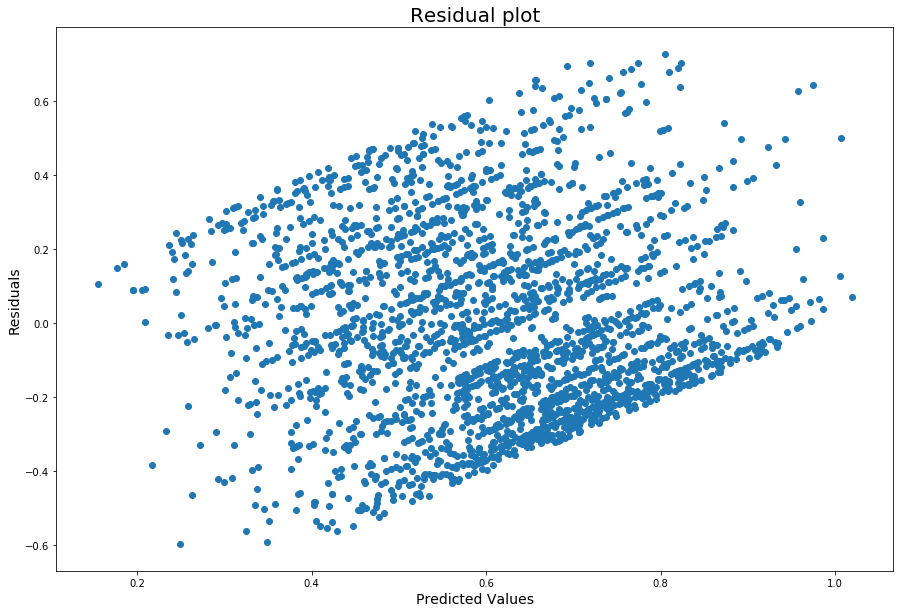

In [545]:
fig, ax = plt.subplots(figsize=(15, 10))
x_plot = plt.scatter(y_prediction, (y_prediction - y_test))
plt.title('Residual plot', fontsize=20)
plt.xlabel('Predicted Values', fontsize=14)
plt.ylabel('Residuals', fontsize=14)

In [532]:
y_test.describe()

,poverty_probability
count,2520.000000
mean,0.612575
std,0.291164
min,0.000000
25%,0.394000
50%,0.633000
75%,0.886000
max,1.000000
